# PubMed-BERT Model Training


## Set Up

In [1]:
# !pip install transformers datasets accelerate evaluate

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
!pwd

/home/ubuntu/capstone-project/notebooks


In [4]:
# cd drive/MyDrive/w210_Capstone/
%cd ..

/home/ubuntu/capstone-project


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, Trainer, TrainingArguments
from transformers import AdamW, get_cosine_schedule_with_warmup
from datasets import load_metric, load_dataset

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from logging import warning
import warnings
warnings.filterwarnings('ignore')

In [6]:

if torch.cuda.is_available():
    # device = torch.device("cuda")
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    # device = torch.device("cpu")
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: NVIDIA A10G


## Test Embedding with Bio-BERT

In [7]:
#import the transformers module


#load the pre-trained BioBERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
# tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

# model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
# model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Test Tokenizer
test_smiles1 = "[H][C@]12CC[C@]3([H])[C@]([H])(C[C@@H](O)[C@]4(C)[C@H](CC[C@]34O)C3=CC(=O)OC3)[C@@]1(C)CC[C@@H](C2)O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@H]3C[C@H](O)[C@H](O)[C@@H](C)O3)[C@@H](C)O2)[C@@H](C)O1"
print(tokenizer.tokenize(test_smiles1)[:15])
print(tokenizer.tokenize(test_smiles1)[-15:])

['[', 'h', ']', '[', 'c', '@', ']', '12', '##cc', '[', 'c', '@', ']', '3', '(']
['(', 'c', ')', 'o2', ')', '[', 'c', '@', '@', 'h', ']', '(', 'c', ')', 'o1']


In [9]:
# Test Model Output
#get the input ids and attention mask for SMILES
inputs1 = tokenizer(test_smiles1, return_tensors='pt')
input_ids1 = inputs1["input_ids"]
attention_mask1 = inputs1["attention_mask"]

#get the output of the model
outputs1 = model(input_ids1, attention_mask=attention_mask1)

# Get the last hidden state of the model
# Get the vector for the drug nameby averaging the vectors of each token
# vector1 = outputs1[0].mean(dim=1)
# Get pooler token
vector1 = outputs1[1]


#print the vector
print(vector1.size())
print(vector1[0][:5])

torch.Size([1, 768])
tensor([-0.0364,  0.0445, -0.2951, -0.2320,  0.9554], grad_fn=<SliceBackward0>)


In [10]:
print(input_ids1)

tensor([[    2,    37,    50,    39,    37,    45,    36,    39,  2369,  2437,
            37,    45,    36,    39,    23,    12,    37,    50,    39,    13,
            37,    45,    36,    39,    12,    37,    50,    39,    13,    12,
            45,    37,    45,    36,    36,    50,    39,    12,    57,    13,
            37,    45,    36,    39,    24,    12,    45,    13,    37,    45,
            36,    50,    39,    12,  4928,    37,    45,    36,    39,  3540,
          1037,    13,  8351,    33,  4928,    12,    33,    57,    13,  5084,
          1010,    13,    37,    45,    36,    36,    39,    21,    12,    45,
            13,  4928,    37,    45,    36,    36,    50,    39,    12,  8453,
            13,    57,    37,    45,    36,    50,    39,  6853,    37,    45,
            36,    50,    39,    12,    57,    13,    37,    45,    36,    50,
            39,    12,    57,    37,    45,    36,    50,    39,  6921,    37,
            45,    36,    50,    39,    12,    57,  

In [11]:
# Test Tokenizer
test_smiles2 = "[Cl-].[Cl-].[223Ra++]"
print(tokenizer.tokenize(test_smiles2)[:15])
print(tokenizer.tokenize(test_smiles2)[-15:])

['[', 'cl', '-', ']', '.', '[', 'cl', '-', ']', '.', '[', '223', '##ra', '+', '+']
['cl', '-', ']', '.', '[', 'cl', '-', ']', '.', '[', '223', '##ra', '+', '+', ']']


In [12]:
# Test Model Output
#get the input ids and attention mask for SMILES
inputs2 = tokenizer(test_smiles2, return_tensors='pt')
input_ids2 = inputs2["input_ids"]
attention_mask2 = inputs2["attention_mask"]

#get the output of the model
outputs2 = model(input_ids2, attention_mask=attention_mask2)

# Get the last hidden state of the model
# Get the vector for the drug nameby averaging the vectors of each token
# vector1 = outputs1[0].mean(dim=1)
# Get pooler token
vector2 = outputs2[1]

#print the vector
print(vector2.size())
print(vector2[0][:5])
print(input_ids2)

torch.Size([1, 768])
tensor([-0.7682, -0.0149, -0.1062,  0.0989,  0.7935], grad_fn=<SliceBackward0>)
tensor([[    2,    37,  2111,    17,    39,    18,    37,  2111,    17,    39,
            18,    37, 16975,  5524,    15,    15,    39,     3]])


In [13]:
### COMBINE TWO SMILES TOGETHER
two_smiles = test_smiles1 + " [SEP] " + test_smiles2
inputs = tokenizer(two_smiles, return_tensors='pt')
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

#get the output of the model
outputs = model(input_ids, attention_mask=attention_mask)

# Get the last hidden state of the model
# Get the vector for the drug nameby averaging the vectors of each token
# vector1 = outputs1[0].mean(dim=1)
# Get pooler token
vector = outputs[1]

#print the vector
print(vector.size())
print(vector[0][:5])

torch.Size([1, 768])
tensor([ 0.0994,  0.0146,  0.2288, -0.1278,  0.9769], grad_fn=<SliceBackward0>)


In [14]:
print(input_ids)

tensor([[    2,    37,    50,    39,    37,    45,    36,    39,  2369,  2437,
            37,    45,    36,    39,    23,    12,    37,    50,    39,    13,
            37,    45,    36,    39,    12,    37,    50,    39,    13,    12,
            45,    37,    45,    36,    36,    50,    39,    12,    57,    13,
            37,    45,    36,    39,    24,    12,    45,    13,    37,    45,
            36,    50,    39,    12,  4928,    37,    45,    36,    39,  3540,
          1037,    13,  8351,    33,  4928,    12,    33,    57,    13,  5084,
          1010,    13,    37,    45,    36,    36,    39,    21,    12,    45,
            13,  4928,    37,    45,    36,    36,    50,    39,    12,  8453,
            13,    57,    37,    45,    36,    50,    39,  6853,    37,    45,
            36,    50,    39,    12,    57,    13,    37,    45,    36,    50,
            39,    12,    57,    37,    45,    36,    50,    39,  6921,    37,
            45,    36,    50,    39,    12,    57,  

In [15]:
tokenizer( "[SEP]", return_tensors='pt')

{'input_ids': tensor([[2, 3, 3]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

## Training BioBERT- Frozen All Layers

### Build Model

In [16]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 4
# LEARNING_RATE = 1e-4
LEARNING_RATE = 0.0963  # Not able to converge with this
# MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
WORKERS = int(os.cpu_count())

In [17]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [18]:
# BERT Model
class BioBertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=256, hidden_size2=32, hidden_size3=16, dropout=0.1, unfreeze=False):
        super(BioBertClassification, self).__init__()
        # self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        # self.bert_model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.bert_model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

        # Unfreeze the last DistilBERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'transformer.layer.5.' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size3, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        # hidden_state = bert_output[0]
        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [19]:
# Initialize model
model = BioBertClassification()
model = model.to(device)

#load the pre-trained BioBERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Build DataLoader

In [20]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

df_train = pd.read_csv(train_file, sep='\t')
df_val= pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [21]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        # random_state=42
                       ) 
print(df_val_small.shape)
df_val_small.head(2)

(30000, 9)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
75337,DB09288,DB00867,Propacetamol,Ritodrine,Unknown,0,unknown,CCN(CC)CC(=O)OC1=CC=C(NC(C)=O)C=C1,C[C@@H](NCCC1=CC=C(O)C=C1)[C@@H](O)C1=CC=C(O)C=C1
232107,DB08983,DB00611,Etofibrate,Butorphanol,Unknown,0,unknown,CC(C)(OC1=CC=C(Cl)C=C1)C(=O)OCCOC(=O)C1=CN=CC=C1,[H][C@@]12CC3=C(C=C(O)C=C3)[C@]3(CCCC[C@@]13O)...


In [22]:
## TEST BLOCK - TEST TOKENIZER
# Add features column which is a combination of smiles1 & smiles2
# Truncate each smiles to 254 tokens max, leaving min 3 tokens for CLS & SEP token
seperator = " [SEP] "
max_length = 512
df_val_small["features"] = df_val_small["smiles1"].str[:254] + seperator + ' ' + df_val_small["smiles2"].str[:254]
X_val = df_val_small["features"]
y_val = df_val_small["interaction_type"]

# Tokenize
_encodings = tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_token_type_ids=False,
    return_tensors='pt'
)

_encodings

{'input_ids': tensor([[    2, 21040,    12,  ...,     0,     0,     0],
        [    2,  4928,    12,  ...,     0,     0,     0],
        [    2,  5084,  1009,  ...,     0,     0,     0],
        ...,
        [    2,  5940,    12,  ...,     0,     0,     0],
        [    2,  5940, 15353,  ...,     0,     0,     0],
        [    2,  5084,    37,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [23]:
df_val_small[df_val_small["features"].isnull()]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,features


In [24]:
# prefix = "[CLS] "
seperator = " [SEP] "
max_length = 512

def build_data_loader(df, shuffle=True):
    # Combine SMILES1 & SMILE2 Together, using [SEP] token to distingush between drug1 & drug2
    df["features"] = df["smiles1"].str[:254] + seperator + df["smiles2"].str[:254]
    X = df["features"]
    y = df["interaction_type"]

    # Tokenize
    _encodings = tokenizer(
        list(X.values), 
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True, 
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)

    _dataset = TensorDataset(_ids, _mask, _labels)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader

In [25]:
## Data Loader
train_loader = build_data_loader(df_train)

val_loader = build_data_loader(df_val_small)
val_loader_full = build_data_loader(df_val, shuffle=False)

test_loader = build_data_loader(df_test, shuffle=False)

In [26]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Val Full batches:', len(val_loader_full))
print('Test batches:', len(test_loader))

Train batches: 12500
Val subset batches: 1250
Val Full batches: 9920
Test batches: 7782


### Training

In [27]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adadelta(model.parameters()
                           , lr=LEARNING_RATE
                           # , weight_decay=WEIGHT_DECAY
                          )

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [28]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [29]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader): 
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 200 batches
        if step % 1000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [30]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 1000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [31]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_score = np.array(outputs)
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")
    
    return y_true, y_score, y_pred

In [32]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [33]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

######  Epoch 1/4 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6716  Elapsed: 0:10:21.
Batch 2,000  of  12,500.  Loss 0.7351  Elapsed: 0:20:39.
Batch 3,000  of  12,500.  Loss 0.6409  Elapsed: 0:30:57.
Batch 4,000  of  12,500.  Loss 0.6898  Elapsed: 0:41:15.
Batch 5,000  of  12,500.  Loss 0.7211  Elapsed: 0:51:32.
Batch 6,000  of  12,500.  Loss 0.6345  Elapsed: 1:01:47.
Batch 7,000  of  12,500.  Loss 0.5843  Elapsed: 1:12:05.
Batch 8,000  of  12,500.  Loss 0.5897  Elapsed: 1:22:25.
Batch 9,000  of  12,500.  Loss 0.5516  Elapsed: 1:32:45.
Batch 10,000  of  12,500.  Loss 0.6405  Elapsed: 1:43:04.
Batch 11,000  of  12,500.  Loss 0.4940  Elapsed: 1:53:24.
Batch 12,000  of  12,500.  Loss 0.5047  Elapsed: 2:03:43.

Avg Training Loss 0.6387, Completed in 2:08:55 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.6797  Elapsed: 0:03:32.

Avg Validation Loss 0.6601, Completed in 0:04:27
Validation F2-score: 0.7633
Validation Matthew Correlation Coefficient: 0.2774
Validat

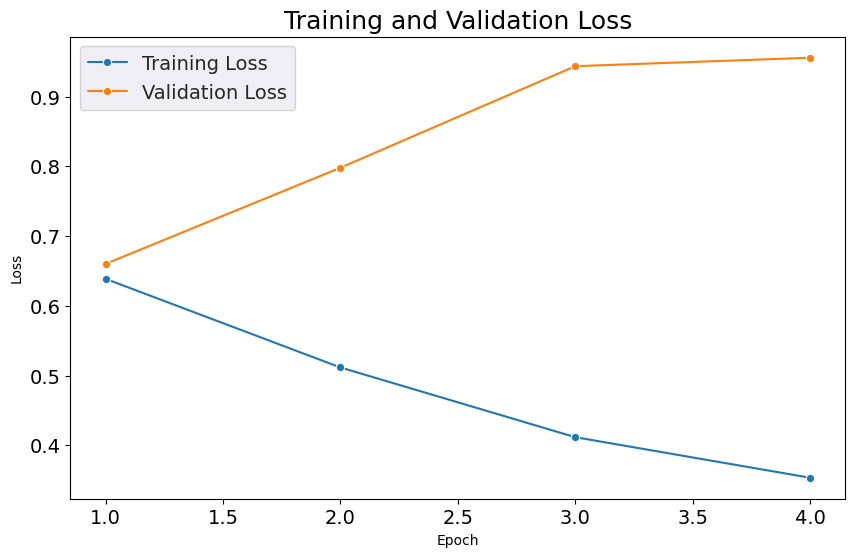

In [34]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [35]:
torch.save(model.state_dict(), 'models/BioBERTFrozen.pth')

### Evaluation

In [36]:
# Predicting with Test Set
print('\nEvaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")


Evaluation metrics for Test Set:
Testing F2-score: 0.7791
Testing Matthew Correlation Coefficient: 0.3569
Testing Recall: 0.7765
Testing Precision: 0.79
Testing Accuracy: 0.7125


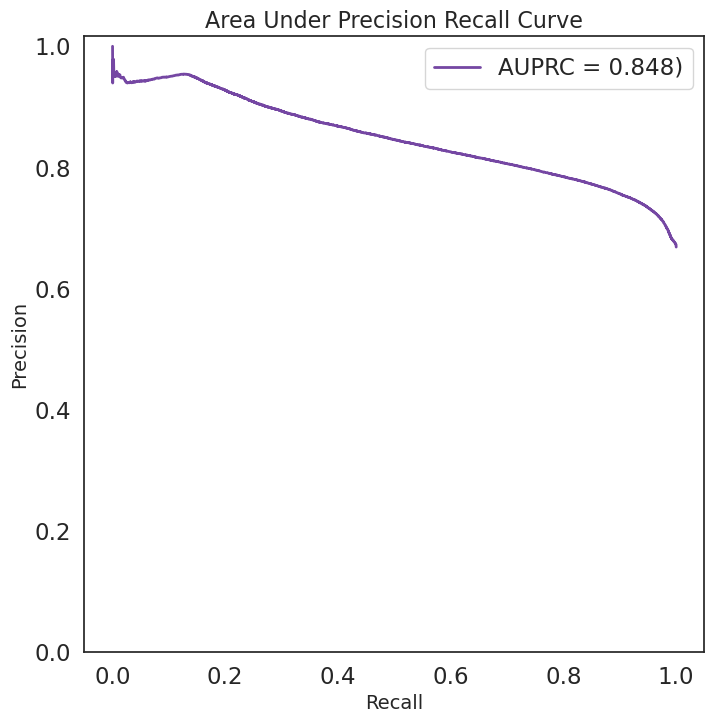

In [37]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [38]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.56      0.58      0.57     61872
     class 1       0.79      0.78      0.78    124881

    accuracy                           0.71    186753
   macro avg       0.68      0.68      0.68    186753
weighted avg       0.72      0.71      0.71    186753



In [39]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[58.33979829, 41.66020171],
       [22.35328032, 77.64671968]])

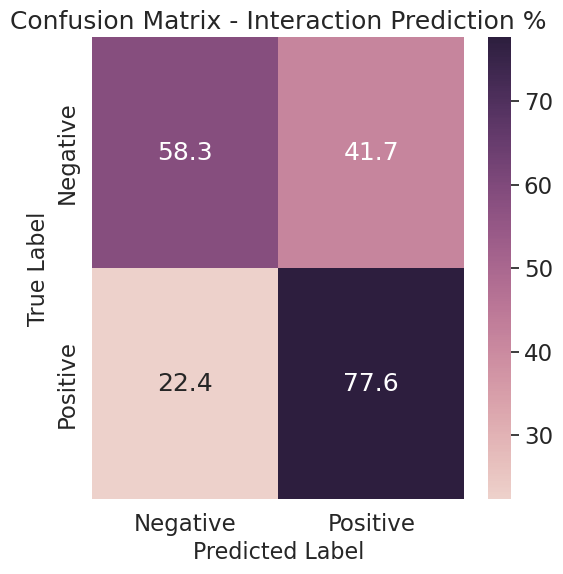

In [40]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Confusion Matrix - Interaction Prediction %", fontsize=18)
    plt.show()

plot_conf_matrix_high(conf_matrix)